# Infectious disease modelling

## The effect of transient behaviour on final epidemic size

With the recent Coronavirus pandemic, a lot of effort has been put into modelling the spread of infectious diseases. The simplest model is known as SIR (Susceptable-Infectious-Recovered) introduced by <cite>Kermack and McKendrick (1927)</cite> is an ODE system of the form 
$$\begin{align}
\dot S_i &= -\lambda_i(t)S_i \\
\dot I_i &= \lambda_i(t)S_i - \gamma I_i \\
\dot R_i &= \gamma I_i 
\end{align}$$

Where $S_i,I_i,R_i$ are susceptable, infectious and recovered percentages of the population $N$ in compartment i such that $\sum_i S_i+I_i+R_i=N$. In its most basic form, this model has only one compartment (i.e the index $i\in \{1\}$). However, if we have $n$ compartments, the linear response from the initial state may have a non-normal matrix contact structure. We first consider the 2 compartment model $$
\begin{align}
\lambda_1(t) = \beta(C_{11}\frac{I_1}{f_1} + C_{12}\frac{I_2}{f_1})\\
\lambda_2(t) = \beta(C_{21}\frac{I_1}{f_2} + C_{22}\frac{I_2}{f_2})
\end{align}$$

where our contact matrix obeys $f_1 C_{12} = f_2 C_{21}$ where $f_i = \frac{N_i}{N}$ is the fraction of the population in each compartment. If $f_1 = f_2$ then $C$ is symmetric and hence normal. However, there is the possibility for non-normality which we investigate here.

In [1]:
import pyross
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl

In [2]:
M = 2                  # the SIR model has no age structure
# Ni = 1000*np.ones(M)   # so there is only one age group 
N = 100000         # and the total population is the size of this age group

Ni = np.zeros((M))      # population in each group
fi = np.zeros((M))      # fraction of population in age age group
# set the age structure
fi = np.array((0.25, 0.75)) 
for i in range(M):
    Ni[i] = fi[i]*N
    

beta  = 0.02            # infection rate 
gamma = 0.007
gIa   = gamma            # recovery rate of asymptomatic infectives 
gIs   = gamma            # recovery rate of symptomatic infectives 
alpha = 0              # fraction of asymptomatic infectives 
fsa   = 1              # Fraction by which symptomatic individuals do not self isolate


Ia0 = np.array([0,0])     # the SIR model has only one kind of infective 
Is0 = np.array([1,.1])     # we take these to be symptomatic 
R0  = np.array([0,0])     # and assume there are no recovered individuals initially 
S0  = Ni    # so that the initial susceptibles are obtained from S + Ia + Is + R = N
### No f_i present here
    
# set the contact structure
C11, C22, C12 = 1,1,4
C = np.array(([C11, C12], [C12*fi[1]/fi[0], C22]))

# if Ni[0]*C[0,1]!=Ni[1]*C[1,0]:
#     raise Exception("invalid contact matrix")

# there is no contact structure
def contactMatrix(t):   
    return C 

# duration of simulation and data file
Tf = 160;  Nt=160; 

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)

# simulate model 
data = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)

In [3]:
# matrix for linearised dynamics
C=contactMatrix(0)
A=((beta*C-gamma*np.identity(len(C))).T*fi).T/fi
mcA=pyross.contactMatrix.characterise_transient(A, ord=1)
AP = A-np.max(np.linalg.eigvals(A))*np.identity(len(A))
mcAA = pyross.contactMatrix.characterise_transient(AP,ord=1)
print(mcAA)

[0.0000000e+00+0.j 2.3476927e-01+0.j 3.0905325e+00+0.j 1.1283435e+03+0.j
 6.9333333e-01+0.j]


Kreiss constant of $\Gamma = A-\lambda_{Max}A$ is ~3.09

/home/ab/python/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


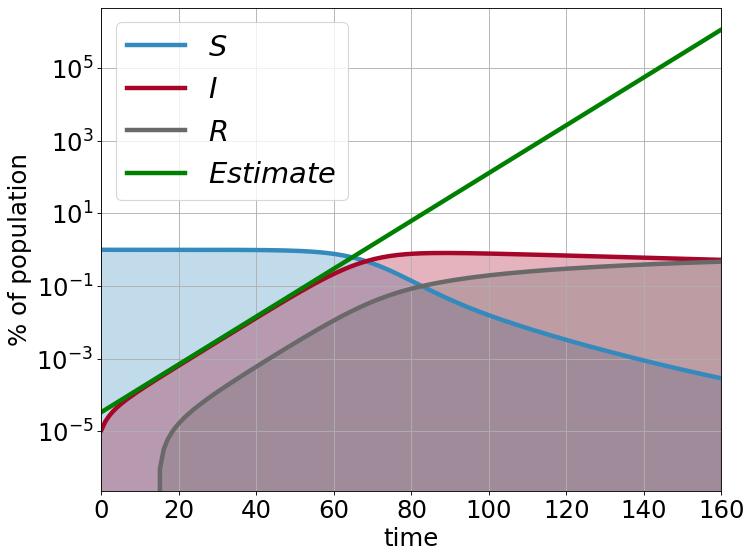

In [4]:
# plot the data and obtain the epidemic curve
Sa  = data['X'][:,:1].flatten()
Sk  = data['X'][:,1:M].flatten()
St=Sa+Sk
# Ia = data['X'][:,1].flatten()
Isa = data['X'][:,2*M:2*M+1].flatten()
Isk = data['X'][:,2*M+1:3*M].flatten()
It = Isa + Isk
# It = np.sqrt(Isa**2 + Isk**2)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, St/N, color="#348ABD", alpha=0.3)
plt.plot(t, St/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, It/N, color='#A60628', alpha=0.3)
plt.plot(t, It/N, '-', color='#A60628', label='$I$', lw=4)

Rt=N-St-It; plt.fill_between(t, 0, Rt/N, color="dimgrey", alpha=0.3)
plt.plot(t, Rt/N, '-', color="dimgrey", label='$R$', lw=4)


plt.autoscale(enable=True, axis='x', tight=True)

###Estimate from Kreiss constant
plt.plot(t,mcAA[2]*It[0]*np.exp(mcA[0]*t)/N,'-', color="green", 
         label='$Estimate$', lw=4)
# plt.ylim([0,1])
plt.yscale('log')
# plt.xlim([0,60])
plt.xlabel("time")
plt.ylabel("% of population")
plt.legend(fontsize=26); plt.grid() 

/home/ab/python/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


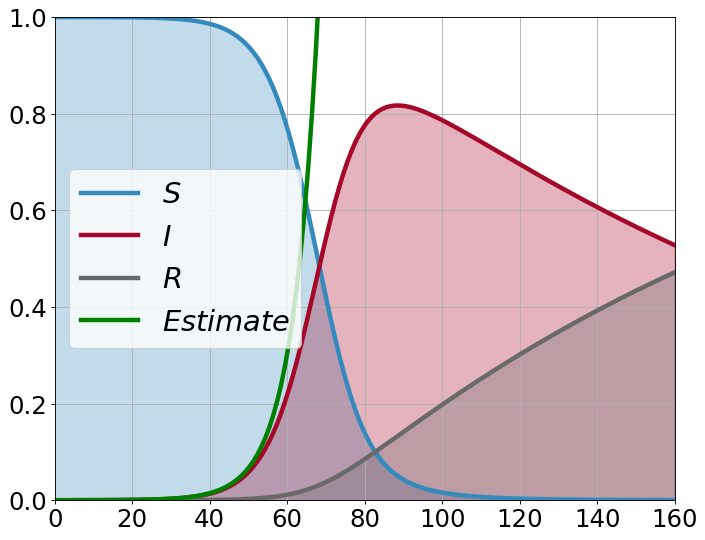

In [5]:
# plot the data and obtain the epidemic curve
Sa  = data['X'][:,:1].flatten()
Sk  = data['X'][:,1:M].flatten()
St=Sa+Sk
Isa = data['X'][:,2*M:2*M+1].flatten()
Isk = data['X'][:,2*M+1:3*M].flatten()
It = Isa + Isk
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


plt.fill_between(t, 0, St/N, color="#348ABD", alpha=0.3)
plt.plot(t, St/N, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, It/N, color='#A60628', alpha=0.3)
plt.plot(t, It/N, '-', color='#A60628', label='$I$', lw=4)

Rt=N-St-It; plt.fill_between(t, 0, Rt/N, color="dimgrey", alpha=0.3)
plt.plot(t, Rt/N, '-', color="dimgrey", label='$R$', lw=4)



###Estimate from Kreiss constant
plt.plot(t,mcAA[2]*It[0]*np.exp(mcA[0]*t)/N,'-', color="green", 
         label='$Estimate$', lw=4)
plt.ylim([0,1])
# plt.yscale('log')

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
# plt.xlim([0,100])


The only pitfall is that we need to specify the order of the spectral norm. Most physics processes naturally take place in an $L2$ norm space. However, here we are interested in $I_{total} = \sum_n I_n$ which is an $L1$ norm. This option can be specified in `characterise_transient`.